https://www.pnas.org/doi/full/10.1073/pnas.1419161111

# Data Download - Rakshya
# Align the reads, Identify AS events and calculate inclusion level, Visualize Inclusion Count - Rakshya
# Statistical Analysis (Standard Deviation, Coorelation ....) - Gillian, Rakshya and Vrishab
# Visualization using Matplotlib - Vrishab
# Output of the data and documentation - Kristel

# BME160 Final Project

In [1]:
!pip install biopython
!pip install pysam
!pip install pandas
!pip install numpy
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.4/988.4 kB 9.7 MB/s eta 0:00:0000:0100:01


# How to download RNA seq data from [NCBI SRA](https://www.ncbi.nlm.nih.gov/sra)

More detailed explanation here : https://www.ncbi.nlm.nih.gov/sra/docs/sradownload/

Brief Description

1.   Click on the link https://www.ncbi.nlm.nih.gov/sra
2.   Then on the search bar type RNA-seq of .....(I typed RNA-Seq of Colorectal Cancer)
3.   Click on the file you want to download
4.   After that copy the Run ID 
5.   data below 5gb can be downloaded from here https://www.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&display=metadata
6.   data greater than 5gb needs to be downloaded from SRA toolkit

SRA toolkit installation steps in MacOS terminal

```zsh
$curl --output sratoolkit.tar.gz https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-mac64.tar.gz

$tar -vxzf sratoolkit.tar.gz

$export PATH=$PATH:/Users/rausharm/BME160/sratoolkit.3.0.5-mac64/bin\n

$source ~/.zshrc

$/Users/rausharm/BME160/sratoolkit.3.0.5-mac64/bin/vdb-config -i

$/Users/rausharm/BME160/sratoolkit.3.0.5-mac64/bin/fastq-dump

$which fastq-dump

$fastq-dump --stdout -X 2 SRR390728
```
OUTOUT
```zsh
Read 2 spots for SRR390728
Written 2 spots for SRR390728
@SRR390728.1 1 length=72
CATTCTTCACGTAGTTCTCGAGCCTTGGTTTTCAGCGATGGAGAATGACTTTGACAAGCTGAGAGAAGNTNC
+SRR390728.1 1 length=72
;;;;;;;;;;;;;;;;;;;;;;;;;;;9;;665142;;;;;;;;;;;;;;;;;;;;;;;;;;;;;96&&&&(
@SRR390728.2 2 length=72
AAGTAGGTCTCGTCTGTGTTTTCTACGAGCTTGTGTTCCAGCTGACCCACTCCCTGGGTGGGGGGACTGGGT
+SRR390728.2 2 length=72
;;;;;;;;;;;;;;;;;4;;;;3;393.1+4&&5&&;;;;;;;;;;;;;;;;;;;;;<9;<;;;;;464262
```

Data downloaded: Prostate Cancer
https://www.ncbi.nlm.nih.gov/sra/SRX20484591[accn]

Run Id: SRR24705928

Run Browser for data:https://www.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser

# Align it with the reference genome
https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.40

Downloaded both Genomic Fasta and RNA fasta 

- Easiest way to aligh might be using online resources like https://usegalaxy.org
- Encountered an error because the genome indexing process requires more RAM than has been allocated. So, using the built-in GRhg38.
- Sucessfully aligned it to the hg38 and for the files. 
- Steps followed:
    - Click the link https://usegalaxy.org and in the search bar type " RNA STAR"
    - Then upload the RNA-seq prostate cancer data 
    - Choose the built-in reference file
    - Chose the default settings for now
    - Press Run tool
    - Wait for the taks to complete
    - The run created junctions.bed and bam file.

The code below is reading the output generated after aligning them to reference sequence using pysam and pandas dataframe. I have printed first ten lines as its a huge data and also printed the junction bed files. 

In [1]:
import pysam
import pandas as pd

bamfile = pysam.AlignmentFile("/Users/rausharm/BME160/finalproject/test.bam", "rb")

for i, read in enumerate(bamfile):
    if i >= 10:
        break
    print("Read name:", read.query_name)
    print("Reference start:", read.reference_start)
    print("Reference end:", read.reference_end)

bedfile = pd.read_table("/Users/rausharm/BME160/finalproject/test.bed", header=None)

# Print the DataFrame
print("printing bedfile",bedfile)


Read name: SRR24705928.2187843.1
Reference start: 12047
Reference end: 12197
Read name: SRR24705928.8318093.1
Reference start: 12828
Reference end: 12978
Read name: SRR24705928.716489.1
Reference start: 13090
Reference end: 183735
Read name: SRR24705928.2317637.1
Reference start: 13505
Reference end: 13655
Read name: SRR24705928.3680583.1
Reference start: 14042
Reference end: 14179
Read name: SRR24705928.20507463.1
Reference start: 14054
Reference end: 14204
Read name: SRR24705928.6857283.1
Reference start: 14063
Reference end: 14213
Read name: SRR24705928.18334031.1
Reference start: 14067
Reference end: 14217
Read name: SRR24705928.3874535.1
Reference start: 14445
Reference end: 14568
Read name: SRR24705928.3876489.1
Reference start: 14445
Reference end: 14568
printing bedfile                        0      1       2  3  4  5  6   7   8
0                   chr1  14830   14969  2  2  0  0  33  71
1                   chr1  14830   15020  2  2  0  0   3  39
2                   chr1  14830

[E::idx_find_and_load] Could not retrieve index file for '/Users/rausharm/BME160/finalproject/test.bam'


# Identify Alternative Splicing Events
The code below analyze a BAM file containing RNA-seq data and determine the number of reads that support alternative splicing. Alternative splicing is a process in which different combinations of exons are included or excluded from the final mRNA transcript, leading to the generation of multiple protein isoforms from a single gene.

The code first defines a function detect_alternative_splicing that checks if a read spans multiple exons, indicating the presence of alternative splicing. It then opens the BAM file and iterates over each read. For each read, the code calls the detect_alternative_splicing function and increments counters for the total number of reads and the number of reads supporting alternative splicing.

The output of the code is the total number of reads and the number of reads that exhibit alternative splicing events. We get occurrence of alternative splicing events


In [19]:
def detect_alternative_splicing(read):
    blocks = read.get_blocks()

    # Check if the read starts and ends in different blocks
    if len(blocks) > 1:
        return True
    else:
        return False

bamfile = pysam.AlignmentFile("/Users/rausharm/BME160/finalproject/test.bam", "rb")

bedfile = pd.read_table("/Users/rausharm/BME160/finalproject/test.bed", header=None)

total_reads = 0
alternative_splicing_events = 0

for read in bamfile:
    # Check if the read supports alternative splicing
    if detect_alternative_splicing(read):
        alternative_splicing_events += 1
    total_reads += 1

print("Total Reads:", total_reads)
print("Alternative Splicing Events:", alternative_splicing_events)

bamfile.close()

[E::idx_find_and_load] Could not retrieve index file for '/Users/rausharm/BME160/finalproject/test.bam'


Total Reads: 12559327
Alternative Splicing Events: 3968412


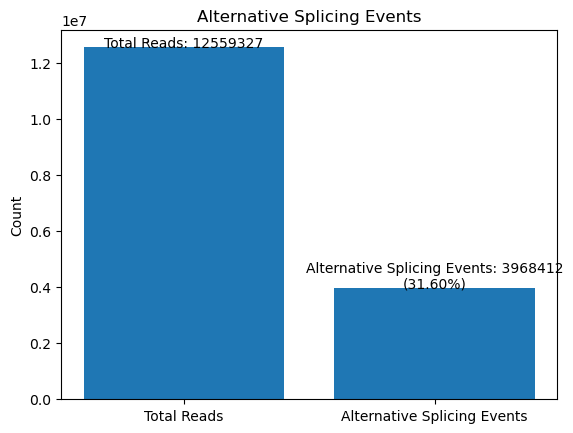

In [20]:
import matplotlib.pyplot as plt

# Define the data
total_reads = 12559327
alternative_splicing_events = 3968412

# Calculate the percentage of alternative splicing events
percentage = (alternative_splicing_events / total_reads) * 100

# Create a bar plot
x = ['Total Reads', 'Alternative Splicing Events']
y = [total_reads, alternative_splicing_events]

plt.bar(x, y)
plt.ylabel('Count')
plt.title('Alternative Splicing Events')
plt.text(0, total_reads, f'Total Reads: {total_reads}', ha='center')
plt.text(1, alternative_splicing_events, f'Alternative Splicing Events: {alternative_splicing_events}\n({percentage:.2f}%)', ha='center')

# Show the plot
plt.show()


# Analyzing CIGAR Strings in RNA-seq Data

The code reads a BAM file containing the alignment information of the RNA-seq reads. It iterates over each read in the file and checks if it is aligned and contains splicing events. It extracts the CIGAR string from the read, which represents the alignment and possible gaps/splicing events.

Using the CIGAR string, the code constructs a splicing pattern representation by assigning "M" to represent included exons and "N" to represent skipped exons. It keeps track of the count for each unique splicing pattern observed.

The code provides insights into the specific splicing patterns present in the RNA-seq data, which can be helpful in studying alternative splicing events. 

In [38]:
"""
"M" represents an included exon, indicating that the exon is present in the transcript produced from 
the alternative splicing event.

"N" represents a skipped exon, indicating that the exon is not included in the transcript produced from 
the alternative splicing event.
"""

# Open the BAM file
bamfile = pysam.AlignmentFile("/Users/rausharm/BME160/finalproject/test.bam", "rb")


splicing_patterns = {}

# Set the maximum number of reads to process couldn't exceed 100
max_reads = 90

for i, read in enumerate(bamfile):
    if read.is_unmapped:
        continue
    
    # Extract the cigar string from the read
    cigar = read.cigarstring
    

    if not cigar or "N" not in cigar:
        continue
    

    splicing_pattern = ""
    for op, length in read.cigartuples:
        if op == 0 or op == 2:
            splicing_pattern += length * "M"
        elif op == 3:
            splicing_pattern += length * "N"
    

    if splicing_pattern in splicing_patterns:
        splicing_patterns[splicing_pattern] += 1
    else:
        splicing_patterns[splicing_pattern] = 1
    

    if i >= max_reads:
        break


bamfile.close()

total_reads = sum(splicing_patterns.values())

# Calculate the frequencies of each splicing pattern
splicing_pattern_frequencies = {}
for splicing_pattern in splicing_patterns:
    if splicing_pattern in splicing_pattern_frequencies:
        splicing_pattern_frequencies[splicing_pattern] += 1
    else:
        splicing_pattern_frequencies[splicing_pattern] = 1


for splicing_pattern, frequency in splicing_pattern_frequencies.items():
    print("Splicing Pattern:", splicing_pattern)
    print("Frequency:", frequency)
    print()

Splicing Pattern: MMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

[E::idx_find_and_load] Could not retrieve index file for '/Users/rausharm/BME160/finalproject/test.bam'


# Perform Statistical Analysis for the cancer data

In [39]:
import numpy as np
# Calculate the frequencies and standard deviation
frequencies = np.array(list(splicing_pattern_frequencies.values())) / total_reads
std_deviation = np.std(frequencies)

# Print the results
print("Total Reads:", total_reads)
print("Number of Splicing Patterns:", len(splicing_pattern_frequencies))
print("Standard Deviation of Frequencies:", std_deviation)

Total Reads: 44
Number of Splicing Patterns: 37
Standard Deviation of Frequencies: 3.469446951953614e-18


# Convert the data that could be used to Matplotlib

# Visualize the data using Matplotlib

# Output the data in tsv of csv file